In [1]:
import os, json
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import models 

# ----
from data.dataset import FoodImageDataset
import custom_models

In [ ]:
torch.cuda.is_available()

In [ ]:
df_train = pd.DataFrame({"filename":os.listdir("../../train")})
df_val = pd.DataFrame({"filename":os.listdir("../../val")})

def get_class(filename):
    info = filename.split("-")
    return info[1]

df_train["class"] = df_train["filename"].apply(lambda x: get_class(x))
df_val["class"] = df_val["filename"].apply(lambda x: get_class(x))



names = []
for i in df_val["class"].unique(): 
    if i not in df_train["class"].unique():
        names.append(i)

print(len(names))

df_val["class"].value_counts()

In [ ]:
import logging
from datetime import datetime

# 配置日志
logging.basicConfig(
    filename=f'training_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log',
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# 记录超参数
params = {
    'batch_size': 32,
    'lr': 0.001,
    'epochs': 10
}
logging.info(f"Hyperparameters: {params}")

# 模拟训练循环
for epoch in range(params['epochs']):
    train_loss = 0.1 * (0.9 ** epoch)  # 示例损失
    val_loss = 0.2 * (0.9 ** epoch)
    logging.info(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

In [ ]:
df = pd.DataFrame({"file_name": os.listdir("../../val")})

def process(file_name):
    info = file_name.split("-")
    return info[1] if len(info) == 3 else info
df['class'] = df['file_name'].apply(lambda x: process(x))
df['class'].value_counts()

In [ ]:
config = json.load(open('./config.json'))
mapping = json.load(open('./mapping.json'))
config

In [ ]:
train_foodimages = FoodImageDataset(config["dataset"]["train_path"])
val_foodimages = FoodImageDataset(config["dataset"]["val_path"])
train_loader = DataLoader(train_foodimages, batch_size=config["train"]["batch_size"], shuffle=True)
val_loader = DataLoader(val_foodimages, batch_size=config["train"]["batch_size"], shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
# 训练函数
def train_model(model, train_loader, val_loader):
    # 根据配置文件定义超参数
    lr = config["train"]["lr"]
    num_epochs = config["train"]["num_epochs"]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"using {device}")
    
    # 移动模型到指定设备
    model = model.to(device)
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 统计
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels.max(1)[1]).sum().item()
        
        train_acc = 100. * train_correct / train_total
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * val_correct / val_total
        
        
        # 保存最佳模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        # 打印训练信息
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        print('--------------------')
        
model = custom_models.FRM_20250213_1()
train_model(model, train_loader, val_loader)

In [ ]:
import json
config = json.load(open('./config.json'))

for k, v in config.items():
    print(k)
    for kk, vv in v.items():
        print(f"--{kk}: {vv}")


In [7]:
import os, json
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from IPython.display import Image as ipython_Image

In [ ]:


train_img_path = "../dataset/train"

test_img_path = os.path.join(train_img_path, os.listdir(train_img_path)[0])



ipython_Image(filename=test_img_path) 

In [ ]:
Image.open(test_img_path).convert('RGB')

transform = transforms.Compose([
                transforms.Resize((256, 256)),
            ])
new_img = transform(Image.open(test_img_path))

new_img

In [ ]:
import os, json

config = json.load(open('./config.json'))


dict(zip(set(i.split("-")[1] for i in os.listdir(config["dataset"]["train_path"])), range(config["model"]["num_classes"])))

In [ ]:
set(i.split("-")[1] for i in os.listdir(config["dataset"]["train_path"]))

In [ ]:
import os, json

config = json.load(open('./config.json'))

if not config["train"]["use_wandb"]:
    print(1)

In [ ]:
import json, os
from PIL import Image

config = json.load(open('./config.json'))

display_num = 100
img_path = config["dataset"]["train_path"]
for i in os.listdir(img_path):
    if display_num == 0:
        break
    display_num -= 1
    print(Image.open(os.path.join(img_path, i)).size)


In [ ]:
import json
import pandas as pd


origin = json.load(open('./temp.json'))


In [ ]:
import torch

if torch.cuda.is_available():
    # 获取当前使用的 GPU 设备编号
    current_device = torch.cuda.current_device()
    # 获取该 GPU 的具体型号
    gpu_name = torch.cuda.get_device_name(current_device)
    print(f"当前正在使用的 GPU 型号是: {gpu_name}")
else:
    print("当前没有可用的 GPU，正在使用 CPU 进行推理。")

In [ ]:
import os, json, time
import torch
from PIL import Image
from data.transform import FoodImageTransform
from model import Model
config = json.load(open("config.json", "r", encoding="utf-8"))

model_state_path = "./vit_128_0.0001_0.2_DA-2-20250330143538-best_model.pth"

# 加载模型
model = Model(config["inference"]["name"]).get_model()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 读取模型参数
if not os.path.exists(model_state_path):
    raise FileNotFoundError(f"not found model state file: {model_state_path}")

state_dict = torch.load(model_state_path, map_location=device)
model.load_state_dict(state_dict)


model.to(device)
model.eval()


In [ ]:
def inference(image_path):
    start_time = time.time()
    # 加载图像
    image = Image.open(image_path).convert("RGB")
    # 图像预处理
    image_tensor = FoodImageTransform(transform_type=0)(image).unsqueeze(0).to(device)# 添加批次维度并移动到GPU

    # 推理
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
        
    # 获取最可能类别的索引和置信度
    confidence, class_idx = torch.max(probabilities, 0)
    confidence_value = confidence.item() * 100
    print(f"time: {time.time() - start_time:.2f} s, class_idx: {class_idx.item()}, confidence_value: {(confidence_value):.2f}%")

val_dir = config["train"]["dataset"]["val_path"]
for loc, i in enumerate(os.listdir(val_dir)):
    print(f"[{loc}/{len(os.listdir(val_dir))}] file name: {i}", end=" ")
    inference(os.path.join(val_dir, i))


In [ ]:
import json
json.load(open("food-info.json", "r", encoding="utf-8"))

In [ ]:
import os
from tqdm import tqdm
import pandas as pd
from InferenceEngine import InferenceEngine

InferenceEngine = InferenceEngine()


def work(target_dir, key):
    count = 0 # 计数
    
    total = len(os.listdir(target_dir))
    info_dict = {"file_name":[],
                "food_name":[],
                "confidence":[]}   
    for i in tqdm(os.listdir(target_dir)):
        if i.endswith(".jpg"):
            infer_info = InferenceEngine.inference(os.path.join(target_dir, i))
            info_dict["file_name"].append(i)
            info_dict["food_name"].append(infer_info["food_name"])
            info_dict["confidence"].append(infer_info["confidence"])
            
            if int(infer_info["confidence"]) < key:
                count += 1
    print(f"The number of inference's confience is {count} ({count/total*100:.2f})%")
    csv_path = f"./{target_dir.split("/")[-1]}-analysis.csv"
    pd.DataFrame(info_dict).to_csv(csv_path, index=False)
    print(f"csv file saved: {csv_path}")

train_dir = "../dataset/train-256"
val_dir = "../dataset/val-256"
    
work(train_dir, 50)
work(val_dir, 50)

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import shutil, os

In [ ]:
train_info = pd.read_csv("./train-256-analysis.csv")
train_info['label'] = train_info["file_name"].apply(lambda x: x.split("-")[1])
train_info

In [ ]:
train_info[train_info["confidence"] < 70]

In [ ]:
temp = train_info[train_info["confidence"] < 70].value_counts("label").reset_index()
temp["label"] = temp["label"].astype(int)
temp = temp.sort_values("label")

plt.bar(temp["label"], temp["count"])
plt.show()

In [63]:
origin_dir = "../dataset/train-256"
target_dir = "../dataset/new-train-256"

exclude = train_info[train_info["confidence"] < 70]["file_name"].to_list()

for i in os.listdir(origin_dir):
    if i.endswith(".jpg") and i not in exclude:
        shutil.copy(os.path.join(origin_dir, i),
                    os.path.join(target_dir, i))
        

In [64]:
val_info = pd.read_csv("./val-256-analysis.csv")
val_info['label'] = val_info["file_name"].apply(lambda x: x.split("-")[1])
val_info

,file_name,food_name,confidence,label
0,img-0-13113t1.jpg,苦瓜炒豆腐,99.997735,0
1,img-0-13113t2.jpg,苦瓜炒豆腐,99.987900,0
2,img-0-13115t1.jpg,苦瓜炒豆腐,99.967372,0
3,img-0-13115t2.jpg,苦瓜炒豆腐,99.663687,0
4,img-0-13123t1.jpg,苦瓜炒豆腐,99.984992,0
...,...,...,...,...
6659,img-99-312509t2.jpg,咖喱面,93.602777,99
6660,img-99-312545t1.jpg,沙嗲,97.721899,99
6661,img-99-312545t2.jpg,咖喱面,91.257614,99
6662,img-99-312556t1.jpg,麻婆豆腐,88.573700,99


In [ ]:
temp = val_info[val_info["confidence"] < 70].value_counts("label").reset_index()
temp["label"] = temp["label"].astype(int)
temp = temp.sort_values("label")

plt.bar(temp["label"], temp["count"])
plt.show()

In [65]:
origin_dir = "../dataset/val-256"
target_dir = "../dataset/new-val-256"

exclude = val_info[val_info["confidence"] < 70]["file_name"].to_list()

for i in os.listdir(origin_dir):
    if i.endswith(".jpg") and i not in val_info[val_info["confidence"] < 70]["file_name"]:
        shutil.copy(os.path.join(origin_dir, i),
                    os.path.join(target_dir, i))
        

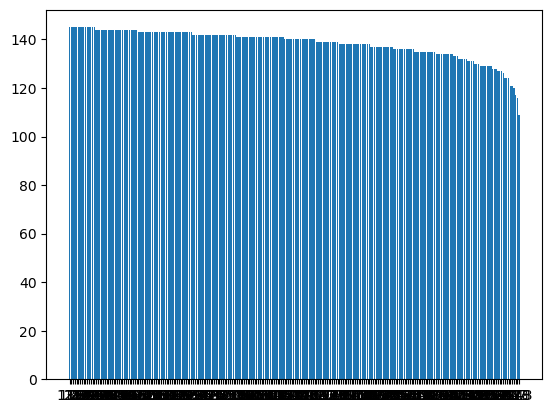

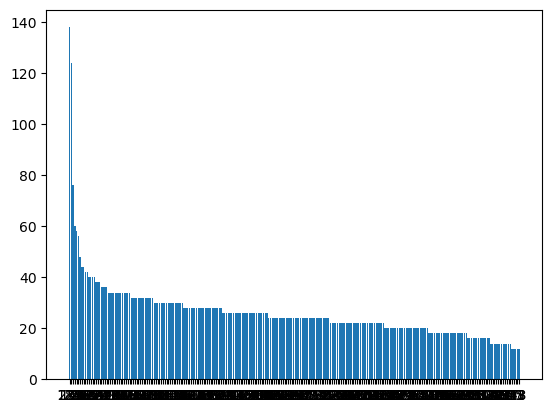

In [69]:
train_dir = "../dataset/new-train-256/"
val_dir = "../dataset/new-val-256"

train_df = pd.DataFrame({"file name": list(os.listdir(train_dir))})
val_df = pd.DataFrame({"file name":list(os.listdir(val_dir))})

train_df['class'] = train_df["file name"].apply(lambda x: x.split("-")[1])
val_df['class'] = val_df["file name"].apply(lambda x: x.split("-")[1])

train_info = train_df.value_counts("class").reset_index()
val_info = val_df.value_counts("class").reset_index()

plt.bar(train_info["class"], train_info["count"])
plt.show()

plt.bar(val_info["class"], val_info["count"])
plt.show()